This notebook compiles a dataset of m_star values and features based on GOTM SMC output. Currently (Oct. 8th, 2025), the features include mean boundary layer depth, constant zonal wind stress, constant heat flux and the local Coriolis frequency. The mean boundary layer depth is averaged over inertial periods of SMC simulations with the total length of 10 days. The first inertial period is discarded from the mean calculation. The m_star mean values are computed in the same fashion.

In [2]:
import xarray as xr
import matplotlib.pyplot as plt
import numpy as np
import os
import json

import torch

In [3]:
def compute_f(latitude: float):
    omega = 2 * np.pi / 24 / 60 / 60
    return 2 * omega * np.sin(np.pi * latitude / 180)

In [4]:
mean_vals = False

data_directory = '../m_star_dataset'
dataset_name = 'ePBL_paper_expanded_2283_corrected'

if mean_vals:
    bl_data = np.load(os.path.join(data_directory, f'{dataset_name}_mean_bls.npy'))
    m_star_data = np.load(os.path.join(data_directory, f'{dataset_name}_mean_m_stars.npy'))
    M_data = np.load(os.path.join(data_directory, f'{dataset_name}_mean_Ms.npy'))

else:
    bl_data = xr.open_dataset(os.path.join(data_directory, f'{dataset_name}_bl.nc'))
    m_star_data = xr.open_dataset(os.path.join(data_directory, f'{dataset_name}_m_star_G.nc'))
    M_data = xr.open_dataset(os.path.join(data_directory, f'{dataset_name}_M.nc'))
    u_data = xr.open_dataset(os.path.join(data_directory, f'{dataset_name}_u_surf.nc'))
    v_data = xr.open_dataset(os.path.join(data_directory, f'{dataset_name}_v_surf.nc'))
    u_bl_data = xr.open_dataset(os.path.join(data_directory, f'{dataset_name}_u_bl.nc'))
    v_bl_data = xr.open_dataset(os.path.join(data_directory, f'{dataset_name}_v_bl.nc'))
    SS_bl_data = xr.open_dataset(os.path.join(data_directory, f'{dataset_name}_SS_bl.nc'))
    NN_bl_data = xr.open_dataset(os.path.join(data_directory, f'{dataset_name}_NN_bl.nc'))

with open(os.path.join(data_directory, f'{dataset_name}_training_set_cases.json'), 'r') as file:
    gotm_case_dict = json.load(file)

# drop out random cases
n_cases = len(gotm_case_dict)
# pick half random cases to drop out
rng = np.random.default_rng(42)
cases_to_drop = np.sort(rng.choice(n_cases, size=int(n_cases/2), replace=False))
cases_to_keep = np.delete(np.arange(n_cases), cases_to_drop)

for case in cases_to_drop:
    gotm_case_dict.pop(f"case_{case+1}")

In [5]:
cases_to_drop

array([   3,    4,    5, ..., 3236, 3237, 3239], shape=(1620,))

In [6]:
cases_to_keep

array([   0,    1,    2, ..., 3233, 3235, 3238], shape=(1620,))

In [7]:
rho0 = 1027

heat_fluxes = np.array([case['heat_flux'] for case in gotm_case_dict.values()])

if mean_vals:

    # coriolis_freqs = np.array([compute_f(case['lat']) for case in gotm_case_dict.values()])[heat_fluxes == 0]
    # u_stars = np.array([(case['tx'] / rho0) ** 0.5 for case in gotm_case_dict.values()])[heat_fluxes == 0]
    # bls = bl_data[heat_fluxes == 0]
    # m_stars = m_star_data[heat_fluxes == 0]
    # Ms = M_data[heat_fluxes == 0]
    
    coriolis_freqs = np.array([compute_f(case['lat']) for case in gotm_case_dict.values()])
    u_stars = np.array([(case['tx'] / rho0) ** 0.5 for case in gotm_case_dict.values()])
    bls = bl_data
    m_stars = m_star_data
    Ms = M_data
    
    xs = bls * coriolis_freqs / u_stars

    # heat_fluxes = heat_fluxes[heat_fluxes == 0]

else:

    # n_cases, t_timesteps = bl_data.bl[heat_fluxes == 0].values.shape
    n_cases, t_timesteps = bl_data.bl.values[cases_to_keep].shape

    coriolis_freqs = np.array([compute_f(case['lat']) for case in gotm_case_dict.values()])
    # temp_grads = np.array([case['temp_grad'] for case in gotm_case_dict.values()])
    u_stars = np.array([(case['tx'] / rho0) ** 0.5 for case in gotm_case_dict.values()])
    taus = np.array([case['tx'] for case in gotm_case_dict.values()])
    bls = bl_data.bl.values[cases_to_keep].flatten()
    # dbl_dt = bl_data.bl[cases_to_keep].diff(dim="time").pad(time=(0,1), mode="constant", constant_values=0).values.flatten() / (60 * 30)
    # bls_im1 = bl_data.bl[cases_to_keep,:-1].pad(time=(1,0), mode="constant", constant_values=0).values.flatten()
    m_stars = m_star_data.m_star.values[cases_to_keep].flatten()
    Ms = M_data.M.values[cases_to_keep].flatten()
    us = u_data.u_surf.values[cases_to_keep].flatten()
    vs = v_data.v_surf.values[cases_to_keep].flatten()
    us_bl = u_bl_data.u_bl.values[cases_to_keep].flatten()
    vs_bl = v_bl_data.v_bl.values[cases_to_keep].flatten()
    SS_bl = SS_bl_data.SS_bl.values[cases_to_keep].flatten()
    NN_bl = NN_bl_data.NN_bl.values[cases_to_keep].flatten()
    ekin = us**2 + vs**2
    ekin_bl = us_bl**2 + vs_bl**2
    
    # coriolis_freqs = np.array([compute_f(case['lat']) for case in gotm_case_dict.values()])[heat_fluxes == 0]
    # u_stars = np.array([(case['tx'] / rho0) ** 0.5 for case in gotm_case_dict.values()])[heat_fluxes == 0]
    # bls = bl_data.bl[heat_fluxes == 0].values.flatten()
    # m_stars = m_star_data.m_star[heat_fluxes == 0].values.flatten()

    coriolis_freqs = np.repeat(coriolis_freqs, t_timesteps)
    # temp_grads = np.repeat(temp_grads, t_timesteps)
    u_stars = np.repeat(u_stars, t_timesteps)
    taus = np.repeat(taus, t_timesteps)
    # xs = bls * coriolis_freqs / u_stars
    heat_fluxes = np.repeat(heat_fluxes, t_timesteps)

    # heat_fluxes = heat_fluxes[heat_fluxes == 0]

In [8]:
# compile test cases dataset

with open(os.path.join(data_directory, f'{dataset_name}_training_set_cases.json'), 'r') as file:
    gotm_dropped_case_dict = json.load(file)

for case in cases_to_keep:
    gotm_dropped_case_dict.pop(f"case_{case+1}")

dropped_heat_fluxes = np.array([case['heat_flux'] for case in gotm_dropped_case_dict.values()])

n_cases, t_timesteps = bl_data.bl.values[cases_to_drop].shape

dropped_coriolis_freqs = np.array([compute_f(case['lat']) for case in gotm_dropped_case_dict.values()])
# dropped_temp_grads = np.array([case['temp_grad'] for case in gotm_dropped_case_dict.values()])
dropped_u_stars = np.array([(case['tx'] / rho0) ** 0.5 for case in gotm_dropped_case_dict.values()])
dropped_taus = np.array([case['tx'] for case in gotm_dropped_case_dict.values()])
dropped_bls = bl_data.bl.values[cases_to_drop].flatten()
# dropped_dbl_dt = bl_data.bl[cases_to_drop].diff(dim="time").pad(time=(0,1), mode="constant", constant_values=0).values.flatten() / (60 * 30)
# dropped_bls_im1 = bl_data.bl[cases_to_drop,:-1].pad(time=(1,0), mode="constant", constant_values=0).values.flatten()
dropped_m_stars = m_star_data.m_star.values[cases_to_drop].flatten()
dropped_Ms = M_data.M.values[cases_to_drop].flatten()
dropped_us = u_data.u_surf.values[cases_to_drop].flatten()
dropped_vs = v_data.v_surf.values[cases_to_drop].flatten()
dropped_ekin = dropped_us**2 + dropped_vs**2
dropped_us_bl = u_bl_data.u_bl.values[cases_to_drop].flatten()
dropped_vs_bl = v_bl_data.v_bl.values[cases_to_drop].flatten()
dropped_SS_bl = SS_bl_data.SS_bl.values[cases_to_drop].flatten()
dropped_NN_bl = NN_bl_data.NN_bl.values[cases_to_drop].flatten()
dropped_ekin_bl = dropped_us_bl**2 + dropped_vs_bl**2

dropped_coriolis_freqs = np.repeat(dropped_coriolis_freqs, t_timesteps)
# dropped_temp_grads = np.repeat(dropped_temp_grads, t_timesteps)
dropped_u_stars = np.repeat(dropped_u_stars, t_timesteps)
dropped_taus = np.repeat(dropped_taus, t_timesteps)
dropped_heat_fluxes = np.repeat(dropped_heat_fluxes, t_timesteps)

if not mean_vals:
    torch_dataset_name = f"{dataset_name}_validation_cases.pt"
    dataset = torch.tensor(np.array([
        dropped_coriolis_freqs, dropped_u_stars, dropped_bls, dropped_heat_fluxes, dropped_us, 
        dropped_vs, dropped_ekin, dropped_us_bl, dropped_vs_bl, dropped_ekin_bl, dropped_SS_bl, dropped_NN_bl, dropped_Ms]))
    torch.save(dataset, os.path.join(data_directory, torch_dataset_name))

In [10]:
with open(os.path.join(data_directory, f'{dataset_name}_training_set_dropped_cases.json'), 'w+') as file:
    json.dump(gotm_dropped_case_dict, file)

In [17]:
gotm_dropped_case_dict['case_4']

{'temp_grad': 0.001, 'tx': 0.1, 'lat': 10.0, 'heat_flux': -25}

In [18]:
gotm_case_dict['case_1']

{'temp_grad': 0.001, 'tx': 0.1, 'lat': 10.0, 'heat_flux': -100}

array([   3,    4,    5, ..., 3236, 3237, 3239], shape=(1620,))

In [36]:
# fig, ax = plt.subplots(1,3, figsize=(10,3))

# ax[0].hist(u_stars, 8, color="black", ec="white")
# ax[0].set_xlabel("$u_*$ [ms$^{-1}$]")
# ax[1].hist(bls, color="black", ec="white")
# ax[1].set_xlabel("$H_{bl}$ [m]")
# # ax[2].hist(heat_fluxes, 9, color="black", ec="white")
# # ax[2].set_xlabel("Heat flux [W/m$^2$]")
# ax[2].hist(m_stars, color="black", ec="white")
# ax[2].set_xlabel("$m_*$")

# fig.tight_layout()

# plt.savefig("idealized_input_distributions_no_hf.png", dpi=300)

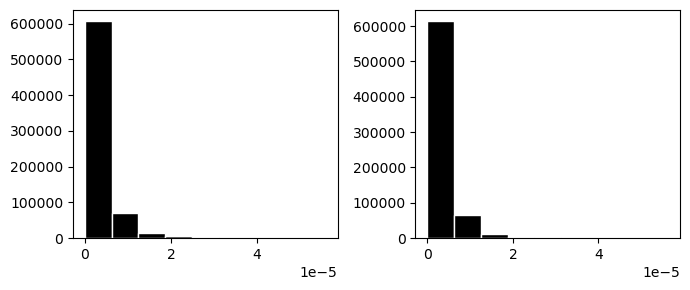

In [37]:
fig, ax = plt.subplots(1,2, figsize=(7,3))

ax[0].hist(Ms, 9, color="black", ec="white")
# ax[0].set_xlabel("$u_*$ [ms$^{-1}$]")
ax[1].hist(dropped_Ms, 9, color="black", ec="white")
# ax[1].set_xlabel("$H_{bl}$ [m]")

fig.tight_layout()

# plt.savefig("idealized_input_distributions_no_hf.png", dpi=300)

In [7]:
angle = np.arccos(us*taus/(np.sqrt(us**2+vs**2)*taus))

/tmp/ipykernel_2724315/3736259665.py:1: RuntimeWarning: invalid value encountered in divide
  angle = np.arccos(us*taus/(np.sqrt(us**2+vs**2)*taus))


In [9]:
magnitude = taus*np.sqrt(us**2+vs**2)

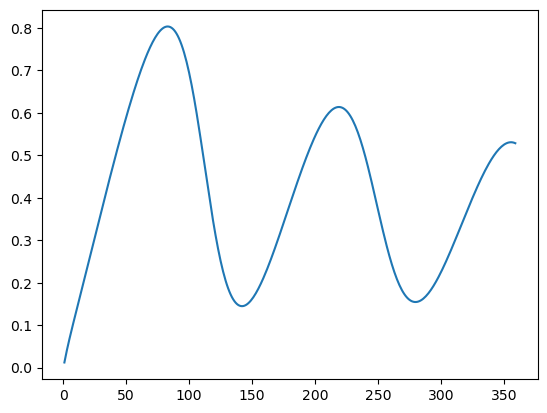

In [ ]:

# plt.plot(us[0:4800])
# plt.plot(vs[0:4800])

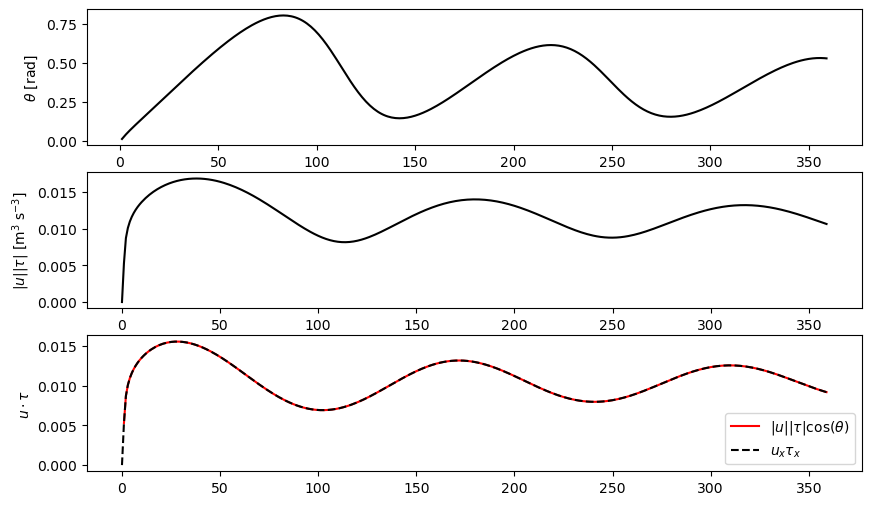

In [39]:
fig, ax = plt.subplots(3,1,figsize=(10,6))

ax[0].set_ylabel(r"$\theta$ [rad]")
ax[0].plot(angle[0:360], color="black")
ax[1].set_ylabel(r"$|u||\tau|$ [m$^3$ s$^{-3}$]")
ax[1].plot(magnitude[0:360], color="black")
ax[2].set_ylabel(r"$u \cdot \tau$")
ax[2].plot(np.cos(angle[0:360])*magnitude[0:360], color="red", label=r"$|u||\tau|\cos(\theta)$")
ax[2].plot(us[0:360]*taus[0:360], color="black", linestyle="dashed", label=r"$u_x\tau_x$")
ax[2].legend()

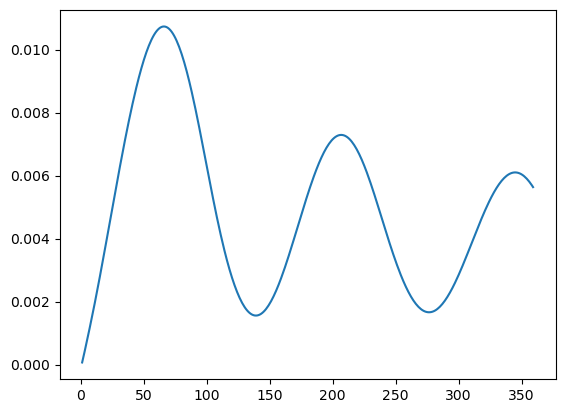

In [27]:
torch_dataset_name = f"{dataset_name}_mean_dataset_M_target.pt" if mean_vals else f"{dataset_name}_dataset_M_target.pt"
dataset = torch.tensor(np.array([
    coriolis_freqs, u_stars, bls, heat_fluxes, us, vs, ekin, us_bl, vs_bl, ekin_bl,
    SS_bl, NN_bl, Ms]))
torch.save(dataset, os.path.join(data_directory, torch_dataset_name))